In [14]:
# ECSE552 Final Project - CNN-Based Multi-Label Model (CelebA)

import os
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50
import torch.nn as nn
import torch.optim as optim

In [15]:
# ========== Step 1: Define Attributes ==========
ATTRIBUTES = [
    "Male", "Young", "Attractive", "Blurry", "Oval_Face", "Chubby", "Double_Chin", "High_Cheekbones",
    "Rosy_Cheeks", "Pale_Skin", "Bald", "Receding_Hairline", "Black_Hair", "Blond_Hair", "Brown_Hair",
    "Gray_Hair", "Straight_Hair", "Wavy_Hair", "Bangs", "Wearing_Hat", "Arched_Eyebrows",
    "Bushy_Eyebrows", "Bags_Under_Eyes", "Narrow_Eyes", "Eyeglasses", "Big_Nose", "Pointy_Nose",
    "Big_Lips", "Mouth_Slightly_Open", "5_o_Clock_Shadow", "Mustache", "Goatee", "Sideburns",
    "No_Beard", "Heavy_Makeup", "Wearing_Lipstick", "Wearing_Earrings", "Wearing_Necklace",
    "Wearing_Necktie", "Smiling"
]

In [16]:
# ========== Step 2: Dataset Class ==========
class CelebAMultiLabel(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform or transforms.Compose([
            transforms.CenterCrop(178),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(os.path.join(self.image_dir, row['filename'])).convert('RGB')
        label = torch.tensor(row[ATTRIBUTES].values.astype('float32'))
        return {'image': self.transform(image), 'label': label}

In [17]:
# ========== Step 3: Model ==========
class CNNMultiLabel(nn.Module):
    def __init__(self, num_labels=40):
        super().__init__()
        base = resnet50(pretrained=True)
        base.fc = nn.Identity()
        self.backbone = base
        self.head = nn.Sequential(
            nn.Linear(2048, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, num_labels)
        )

    def forward(self, x):
        feat = self.backbone(x)
        return self.head(feat)

In [24]:
# ========== Step 4: Evaluation Function ==========
def evaluate(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            x = batch['image'].to(device)
            y = batch['label'].to(device)
            out = model(x)
            preds = (torch.sigmoid(out) > 0.5).float().cpu()
            all_preds.append(preds)
            all_labels.append(batch['label'])
    preds = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    acc = (preds == labels).float().mean().item()
    f1 = f1_score(labels, preds, average='macro')
    print(f"✅ Accuracy: {acc:.4f}, F1-macro: {f1:.4f}")
    return acc, f1

In [19]:
# ========== Step 5: Preprocess Attributes ==========
def convert_attr_txt_to_csv(txt_path, output_csv):
    with open(txt_path, 'r') as f:
        lines = f.readlines()
    header = lines[1].strip().split()
    selected_idx = [i for i, h in enumerate(header) if h in ATTRIBUTES]
    rows = []
    for line in lines[2:]:
        parts = line.strip().split()
        filename = parts[0]
        attrs = [(int(parts[i+1]) + 1) // 2 for i in selected_idx]
        rows.append([filename] + attrs)
    df = pd.DataFrame(rows, columns=['filename'] + ATTRIBUTES)
    df.to_csv(output_csv, index=False)
    print(f"✅ CSV saved: {output_csv}, shape = {df.shape}")

In [20]:
# ========== Step 6: Training + Validation + Test Split ==========
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import torch.optim as optim

# This should be run after converting the attribute file
csv_path = 'data/celeba_multilabel.csv'
image_dir = 'data/img_align_celeba'
partition_path = 'data/list_eval_partition.txt'

if not os.path.exists(csv_path):
    convert_attr_txt_to_csv('data/list_attr_celeba.txt', csv_path)

df = pd.read_csv(csv_path)
with open(partition_path, 'r') as f:
    partition = f.readlines()

partition = [int(line.strip().split()[-1]) for line in partition]
df['partition'] = partition

df[df['partition'] == 0].drop(columns='partition').to_csv('data/train.csv', index=False)
df[df['partition'] == 1].drop(columns='partition').to_csv('data/val.csv', index=False)
df[df['partition'] == 2].drop(columns='partition').to_csv('data/test.csv', index=False)

In [21]:
# ========== Step 7: Train Model ==========
train_set = CelebAMultiLabel('data/train.csv', image_dir, transform=transforms.Compose([
    transforms.CenterCrop(178),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
]))
val_set = CelebAMultiLabel('data/val.csv', image_dir, transform=transforms.Compose([
    transforms.CenterCrop(178),
    transforms.ToTensor()
]))
test_set = CelebAMultiLabel('data/test.csv', image_dir, transform=transforms.Compose([
    transforms.CenterCrop(178),
    transforms.ToTensor()
]))

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNMultiLabel(num_labels=40).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

best_f1 = 0
patience = 3
trigger_times = 0

for epoch in range(1, 21):
    model.train()
    total_loss = 0
    print(f"\n🔁 Epoch {epoch}")
    for batch in tqdm(train_loader):
        x = batch['image'].to(device)
        y = batch['label'].to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"📉 Loss: {total_loss:.2f}")
    acc, f1 = evaluate(model, val_loader, device)
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), 'checkpoints/best_model.pth')
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("🛑 Early stopping")
            break

d:\Anaconda3\envs\torch-gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda3\envs\torch-gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



🔁 Epoch 1


100%|██████████| 5087/5087 [20:37<00:00,  4.11it/s]


📉 Loss: 1176.05
✅ Val Accuracy: 0.9130, F1-macro: 0.6759

🔁 Epoch 2


100%|██████████| 5087/5087 [20:19<00:00,  4.17it/s]


📉 Loss: 1048.48
✅ Val Accuracy: 0.9159, F1-macro: 0.6827

🔁 Epoch 3


100%|██████████| 5087/5087 [19:56<00:00,  4.25it/s]


📉 Loss: 1004.87
✅ Val Accuracy: 0.9158, F1-macro: 0.6872

🔁 Epoch 4


100%|██████████| 5087/5087 [19:55<00:00,  4.26it/s]


📉 Loss: 974.43
✅ Val Accuracy: 0.9181, F1-macro: 0.7099

🔁 Epoch 5


100%|██████████| 5087/5087 [19:56<00:00,  4.25it/s]


📉 Loss: 948.46
✅ Val Accuracy: 0.9183, F1-macro: 0.7021

🔁 Epoch 6


100%|██████████| 5087/5087 [19:53<00:00,  4.26it/s]


📉 Loss: 924.04
✅ Val Accuracy: 0.9189, F1-macro: 0.7171

🔁 Epoch 7


100%|██████████| 5087/5087 [19:56<00:00,  4.25it/s]


📉 Loss: 900.87
✅ Val Accuracy: 0.9169, F1-macro: 0.7193

🔁 Epoch 8


100%|██████████| 5087/5087 [19:59<00:00,  4.24it/s]


📉 Loss: 877.14
✅ Val Accuracy: 0.9174, F1-macro: 0.6955

🔁 Epoch 9


100%|██████████| 5087/5087 [19:56<00:00,  4.25it/s]


📉 Loss: 851.20
✅ Val Accuracy: 0.9165, F1-macro: 0.7103

🔁 Epoch 10


100%|██████████| 5087/5087 [19:56<00:00,  4.25it/s]


📉 Loss: 824.54
✅ Val Accuracy: 0.9170, F1-macro: 0.7299

🔁 Epoch 11


100%|██████████| 5087/5087 [19:57<00:00,  4.25it/s]


📉 Loss: 799.34
✅ Val Accuracy: 0.9166, F1-macro: 0.7161

🔁 Epoch 12


100%|██████████| 5087/5087 [19:54<00:00,  4.26it/s]


📉 Loss: 774.51
✅ Val Accuracy: 0.9157, F1-macro: 0.7194

🔁 Epoch 13


100%|██████████| 5087/5087 [19:57<00:00,  4.25it/s]


📉 Loss: 748.50
✅ Val Accuracy: 0.9149, F1-macro: 0.7114
🛑 Early stopping


In [25]:
# ========== Step 8: Final Test Evaluation ==========
model.load_state_dict(torch.load('checkpoints/best_model.pth'))
evaluate(model, test_loader, device)

C:\Users\Hengyi\AppData\Local\Temp\ipykernel_11016\3913090396.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoints/best_model.pt

✅ Accuracy: 0.9124, F1-macro: 0.7223


(0.9124398827552795, 0.7223332714240698)

✅ Predicted: ['Attractive', 'Rosy_Cheeks', 'Black_Hair', 'Arched_Eyebrows', 'Eyeglasses', 'Sideburns', 'Smiling']
🟩 Ground Truth: ['Attractive', 'Rosy_Cheeks', 'Black_Hair', 'Arched_Eyebrows', 'Eyeglasses', 'Sideburns', 'Wearing_Necktie', 'Smiling']


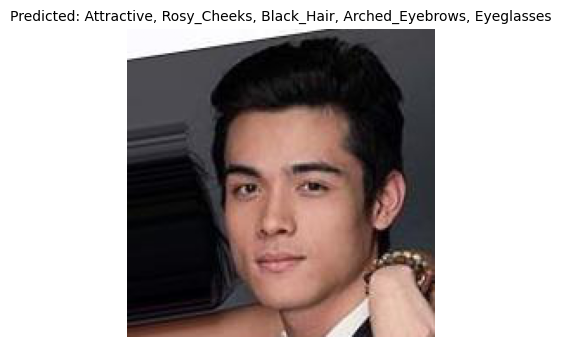

In [26]:
# ========== Step 9: Visualization ==========
import matplotlib.pyplot as plt
import numpy as np
idx = np.random.randint(len(test_set))
sample = test_set[idx]
img = sample['image'].unsqueeze(0).to(device)
true_labels = sample['label']

with torch.no_grad():
    logits = model(img)
    probs = torch.sigmoid(logits).squeeze().cpu().numpy()
    preds = (probs > 0.5).astype(int)

pred_attrs = [ATTRIBUTES[i] for i in range(len(preds)) if preds[i] == 1]
true_attrs = [ATTRIBUTES[i] for i in range(len(true_labels)) if true_labels[i] == 1.0]

plt.figure(figsize=(4,4))
plt.imshow((sample['image'].permute(1,2,0).numpy()))
plt.axis('off')
plt.title("Predicted: " + ", ".join(pred_attrs[:5]), fontsize=10)
print("✅ Predicted:", pred_attrs)
print("🟩 Ground Truth:", true_attrs)
plt.show()


In [28]:
# ========== Step 10: Test Evaluation + Save CSV ==========
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd
import numpy as np

def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            x = batch['image'].to(device)
            y = batch['label'].to(device)

            logits = model(x)
            probs = torch.sigmoid(logits)
            pred_binary = (probs > 0.5).float()

            all_preds.append(pred_binary.cpu().numpy())
            all_labels.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_preds, all_labels


def save_preds_labels_to_csv(all_preds, all_labels, filename="results.csv", attributes=None):
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    if attributes is None:
        attributes = [f"attr_{i}" for i in range(all_preds.shape[1])]

    pred_cols = [f"pred_{attr}" for attr in attributes]
    label_cols = [f"true_{attr}" for attr in attributes]

    df_preds = pd.DataFrame(all_preds, columns=pred_cols)
    df_labels = pd.DataFrame(all_labels, columns=label_cols)

    df = pd.concat([df_preds, df_labels], axis=1)
    df.to_csv(filename, index=False)
    print(f"✅ Saved predictions and labels to {filename}")

# Run test evaluation
all_preds, all_labels = evaluate(model, test_loader, device)

# Optional: print metrics
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"🎯 Test Accuracy: {acc:.4f} | F1-macro: {f1:.4f}")

# Save results to CSV
save_preds_labels_to_csv(all_preds, all_labels, filename="cnn_test_results.csv", attributes=ATTRIBUTES)

🎯 Test Accuracy: 0.0255 | F1-macro: 0.7223
✅ Saved predictions and labels to cnn_test_results.csv
